In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

from importlib import reload

import tree_utils
reload(tree_utils)
from tree_utils import *


In [2]:

data_raw = pd.read_csv("aps_failure_training_set.csv", skiprows = 20)

# Try to understand data
data_raw.shape
data_raw.head()

data_raw_small  = data_raw.iloc[0:10000,:]

#data_raw_small.apply(pd.value_counts)["na"]

from clean_data1 import clean_data
X, Y = clean_data(data_raw_small)

Y.value_counts(normalize=True)

# Y = Y.apply(lambda x: 1 if x =="neg" else 0)
Y.head()


/home/malcolm/Documents/aps_failure/clean_data1.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  data_raw.drop(large_pct_na, axis = 1, inplace= True)


Beginning to drop na's and nan's... this may take a while 
Finished replacing....
Shape before: (10000, 143)
Shape after: (10000, 142)


0    1
1    1
2    1
3    1
4    1
Name: class, dtype: int64

In [4]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.25, random_state = 1)

compare_samples = pd.DataFrame({"Train":y_train.value_counts(normalize=True),
"Test": y_test.value_counts(normalize=True),
"Full":Y.value_counts(normalize=True)})

compare_samples

,Full,Test,Train
1,0.9805,0.9824,0.979867
0,0.0195,0.0176,0.020133


In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
estimator = RandomForestClassifier(n_estimators = 40, max_depth = 4, random_state=4, class_weight={1:10, 0:500})
estimator.fit(X_train, y_train)

estimator.score(X_train, y_train)
preds1 = estimator.predict(X_train)

custom_score_aps(y_train, preds1)

          Pred_0  Pred_1
Actual_0     148       3
Actual_1     267    7082


0.556

          Pred_0  Pred_1
Actual_0      40       4
Actual_1     105    2351


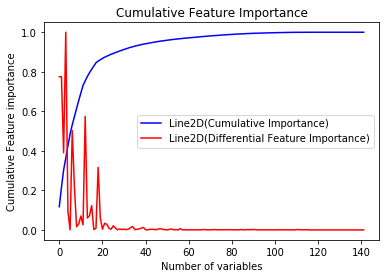

          Pred_0  Pred_1
Actual_0      40       4
Actual_1     105    2351


1.22

In [7]:

preds_test = estimator.predict(X_test)
custom_score_aps(y_test, preds_test)

len(estimator.feature_importances_)

# Feature importance stuff
feat_imp = pd.DataFrame(estimator.feature_importances_, index = X_train.columns, columns = ["Feat_Importance"])

feat_imp2 = get_cum_feat_imp(feat_imp)
plot_cum_feat_imp(feat_imp2)
custom_score_aps(y_test, preds_test)


In [8]:
cum_cutoff = 0.90
indiv_cutoff = 0.002
high_imp_feats1 = feat_imp2[feat_imp2["Cum_Imp"] < cum_cutoff]
len(high_imp_feats1)
high_imp_feats2 = feat_imp[feat_imp["Feat_Importance"] > indiv_cutoff]
len(high_imp_feats2)
high_imp_feats2.head()

,Feat_Importance
aa_000,0.117367
ag_002,0.002832
ag_003,0.008399
ag_004,0.006861
ah_000,0.062258


          Pred_0  Pred_1
Actual_0     148       3
Actual_1     253    7096
          Pred_0  Pred_1
Actual_0      40       4
Actual_1     106    2350


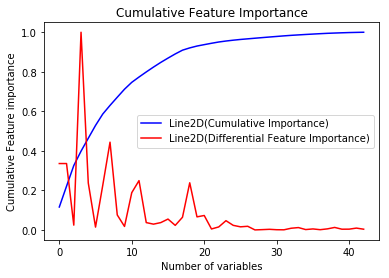

          Pred_0  Pred_1
Actual_0      40       4
Actual_1     105    2351
          Pred_0  Pred_1
Actual_0      40       4
Actual_1     105    2351
          Pred_0  Pred_1
Actual_0      40       4
Actual_1     106    2350


1.224

In [9]:

### Rebuild with variables that passed cutoff
X_train_rf2 = X_train[high_imp_feats2.index]

estimator2 = RandomForestClassifier(n_estimators = 40, max_depth = 4, random_state=4, class_weight={1:10, 0:500})
estimator2.fit(X_train_rf2, y_train)


estimator2.score(X_train_rf2, y_train)

dir(estimator2)
preds2 = estimator2.predict(X_train_rf2)

custom_score_aps(y_train, preds2)

# Test set evaluation
X_test_rf2 = X_test[high_imp_feats2.index]
preds_test2 = estimator2.predict(X_test_rf2)
custom_score_aps(y_test, preds_test2)

len(estimator.feature_importances_)

# Feature importance stuff
feat_imp = pd.DataFrame(estimator2.feature_importances_, index = X_train_rf2.columns, columns = ["Feat_Importance"])

feat_imp2 = get_cum_feat_imp(feat_imp)
plot_cum_feat_imp(feat_imp2)
custom_score_aps(y_test, preds_test)

#### Compare predictions ####
custom_score_aps(y_test, preds_test)
custom_score_aps(y_test, preds_test2)

# Reducing number of parameters doesn't help much


In [11]:
from xgboost import XGBClassifier
import xgboost as xgb

In [12]:

# Set weights for high and low class and set up data frames for xgb
set_weights_tr = [1 if y == 1 else 100 for y in y_train]
xgb_dtrain = xgb.DMatrix(X_train.values, label = y_train, weight = set_weights_tr, feature_names = X_train.columns)
xgb_dtest = xgb.DMatrix(X_test.values, label = y_test, feature_names = X_test.columns)

# Parameters and train model
params = {'max_depth':4, 'eta':0.2, 'silent':1, 'objective':'binary:logistic',
'subsample': 0.5, 'colsample_bytree': 0.5, 'colsample_bylevel':0.7  }
n_rounds = 100
xgb_model = xgb.train(params, xgb_dtrain, n_rounds)



In [ ]:
import tree_utils
reload(tree_utils)
from tree_utils import *


In [ ]:
### Begin model analysis
xg_feat_imp = xgb_model.get_fscore()
xg_feat_imp_pd = pd.DataFrame(xgb_model.get_fscore() , index = ["Feat_Importance_Raw"]).T
xg_feat_imp_pd["Feat_Importance"] = xg_feat_imp_pd["Feat_Importance_Raw"]/xg_feat_imp_pd["Feat_Importance_Raw"].sum()
xg_feat_imp_pd.sort_values(ascending = False, by="Feat_Importance_Raw", inplace= True)

xg_feat_imp2 = get_cum_feat_imp(xg_feat_imp_pd)
plot_cum_feat_imp(xg_feat_imp2)

### Predictions related analysis
xg_preds_test = xgb_model.predict(xgb_dtest)
xg_preds_test_cat = np.array([1 if pred > 0.5 else 0 for pred in xg_preds_test])
custom_score_aps(y_test, xg_preds_test_cat)

custom_score_aps(y_test, preds_test)

y_test.value_counts()

In [ ]:
split_vals = xgb_model.get_split_value_histogram("aa_000")
split_vals["Count"].sum()
# split_vals["Count_pct"] = split_vals["Count"]/split_vals["Count"].sum()
plt.plot(split_vals.iloc[:,0], split_vals.iloc[:,1])
plt.show()

xg_feat_imp_pd.head()

feat_imp2.head()


combine_feat = feat_imp2.join(xg_feat_imp2, lsuffix= "_rf", rsuffix="_xgb")
combine_feat

In [13]:
import lime
import lime.lime_tabular

y_train.unique()

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = X_train.columns, class_names = y_train.unique(), discretize_continuous= True)

TypeError: '<' not supported between instances of 'float' and 'str'